In [94]:
%matplotlib inline 

import pandas
import pickle
import matplotlib.pyplot as plt 
from sklearn import preprocessing, feature_selection

plt.style.use( 'bmh' ) 

In [95]:
# small feature sets, < 100 features per mutant 
feature_sets = [ 
# for thermal paper 
#     'feature_sets/foldx_runs_pssm.csv', 
#     'feature_sets/rosetta_runs_benchmark.csv', 
#     'feature_sets/rosetta_runs_ddg_monomer.csv', 
# # for new-style constraints 
#     'feature_sets/constraint_exploration_run.csv', 
#     'feature_sets/bigger_constraint_exploration_run.csv', 
#     'feature_sets/benchmark_run.csv', 
# for low- and high-resolution ddg protocols 
#     'feature_sets/rosetta_runs__ddg_monomer_low_res.csv', 
#     'feature_sets/rosetta_runs__ddg_monomer_high_res.csv'
# changed to unified naming scheme! 
#     'feature_sets/rosetta_runs__ddg_monomer_low_res.csv', 
    'feature_sets/rosetta_runs__benchmark.csv', 
    'feature_sets/rosetta_runs__ddg_monomer_high_res.csv', 
    'feature_sets/foldx_runs__pssm.csv', 
]

In [96]:
# the four targets we will be using as training data  
target_names = [ 'kcat', 'km', 'kcatkm', 'tm' ] 

In [97]:
# load in experimental data 
target_df = pandas.read_csv( '/Users/alex/Documents/bagel-thermal/data_set/targets.csv', index_col=0 )

In [98]:
# load in additional features
#add = pandas.read_csv( 'feature_sets/add.csv', index_col=0 ) 

In [99]:
# scale features and have in data structure (dict)
features = {}
for feature_set in feature_sets:
    df = pandas.read_csv( feature_set, index_col=0 ) 
    for target in target_names: 
        
        # construct initial df 
        J = target_df[ [ 'target_{}'.format( target ) ] ].join( df ).dropna() # .join( add ).dropna()
        J = J.select_dtypes([ 'float64' ])

        # remove features with variance == 0.0  
        var = feature_selection.VarianceThreshold( 0.01 )
        V = var.fit_transform( J )
        support_indices = var.get_support( indices=True )
        J = pandas.DataFrame( V, columns=J.columns[support_indices] ) 
        scl = preprocessing.RobustScaler()
        
        # scale features 
        y = J.ix[:, 0].ravel() # first column is the target
        X = scl.fit_transform( J.ix[:, 1:] )
        features.update({ ( target, feature_set ): ( X, y, J ) })

In [100]:
targets, feature_sets = zip( *features.keys() )
targets = set( targets ) 
feature_sets = set( feature_sets ) 

In [101]:
# generate tables of feature correlations for Tm paper 
for i, f_set in enumerate( feature_sets ):
    print( 'Feature set:', f_set ) 
    for j, t in enumerate( targets ):
    
        # get data 
        X, y, J = features[ ( t, f_set ) ] 
        
        # assess correlation 
        corr = J.corr()[['target_{}'.format( t )] ].drop( 'target_{}'.format( t ) )
        col_name = 'Pearson correlation to {}'.format( t )
        corr.columns = [ col_name ]
        corr.sort_values( by=col_name, inplace=True ) 
        corr.to_csv( '{}'.format( f_set ).replace('sets', 'correlations').replace('/','/{}__'.format(t)) )
        #print( corr, end='\n\n' ) 

Feature set: feature_sets/rosetta_runs__ddg_monomer_high_res.csv
Feature set: feature_sets/foldx_runs__pssm.csv
Feature set: feature_sets/rosetta_runs__benchmark.csv


In [102]:
# write out the scaled features so we can use in ML notebooks 
with open( 'feature_sets/scaled.pkl', 'wb' ) as fn:
    pickle.dump( features, fn )

### Predicted energies of mutations compared to experimental values 

The predicted total system energies throughout our data set happen to be unique. They are

In [103]:
make_plots = [ 'total', 'total_score', 'total energy' ] 

We can plot the predicted energy against the Tm that we have determined to evaluate the performance of the algorithms underlying the Rosetta simulations. 

Feature set: feature_sets/rosetta_runs__ddg_monomer_high_res.csv


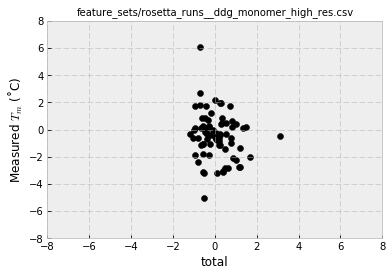

Feature set: feature_sets/foldx_runs__pssm.csv


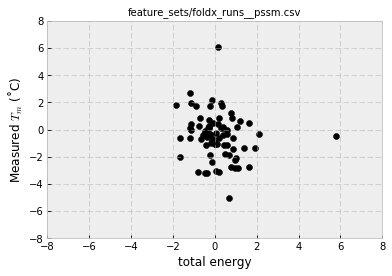

Feature set: feature_sets/rosetta_runs__benchmark.csv


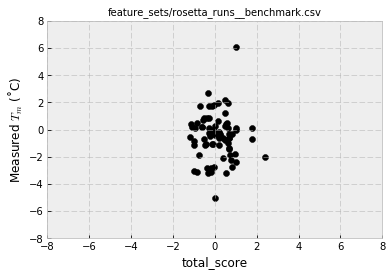

In [104]:
for i, f_set in enumerate( feature_sets ):
    print( 'Feature set:', f_set )
    X, y, J = features[ ( 'tm', f_set ) ]
    X = pandas.DataFrame( X, columns=J.columns[1:] ) 
    corr = J.corr(method='pearson')['target_tm'].drop('target_tm').dropna().sort_values()
    #print( corr )
    for feat in J.columns:
        if feat in make_plots:
            
            # show only middle 90% of data 
            plt.xlim((-8,8))
            plt.ylim((-8,8))
            plt.scatter( X[ feat ], J[ 'target_tm' ], color='k' )
            plt.title( f_set, fontsize='medium' ) 
            plt.xlabel( feat ) 
            plt.ylabel( 'Measured $T_m$ (˚C)' ) 
            plt.show()

Let's try putting them all on the same plot with different colors, to get an idea of how these algorithms perform in general as well as specific cases

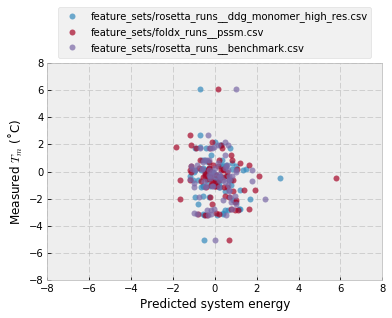

In [105]:
fig, ax = plt.subplots( nrows=1, ncols=1 ) 
for i, f_set in enumerate( feature_sets ):
    X, y, J = features[ ( 'tm', f_set ) ]
    X = pandas.DataFrame( X, columns=J.columns[1:] ) 
    corr = J.corr(method='pearson')['target_tm'].drop('target_tm').dropna().sort_values()
    for feat in J.columns:
        if feat in make_plots:
            ax.set_xlim((-8,8))
            ax.set_ylim((-8,8))
            ax.plot( X[ feat ], J[ 'target_tm' ], 'o', markeredgewidth=0, alpha=0.7 )
            ax.set_xlabel( 'Predicted system energy' ) 
ax.set_ylabel( 'Measured $T_m$ (˚C)' ) 
ax.legend(feature_sets, loc='lower center', bbox_to_anchor=(0.5, 1))

Quantile approach 

Feature set: feature_sets/rosetta_runs__ddg_monomer_high_res.csv
fa_dun        -0.251752
fa_elec       -0.189653
total         -0.164679
hbond_sc      -0.147335
fa_sol        -0.126170
hbond_sr_bb   -0.112117
fa_rep         0.030054
p_aa_pp        0.040258
omega          0.091993
ref            0.143648
fa_atr         0.145811
rama           0.189400
hbond_bb_sc    0.349303
Name: target_tm, dtype: float64


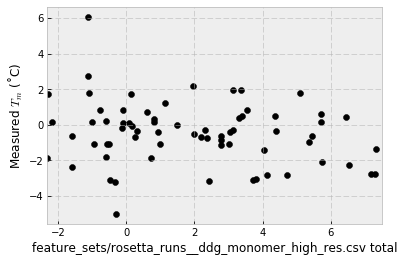


Feature set: feature_sets/foldx_runs__pssm.csv
Electrostatics          -0.248610
Solvation Polar         -0.218667
total energy            -0.179179
energy Ionisation       -0.143117
torsional clash         -0.133841
Van der Waals clashes   -0.121095
Solvation Hydrophobic   -0.048905
entropy sidechain        0.045208
backbone clash           0.075336
Van der Waals            0.076851
Sidechain Hbond          0.091553
entropy mainchain        0.191402
Backbone Hbond           0.295736
Name: target_tm, dtype: float64


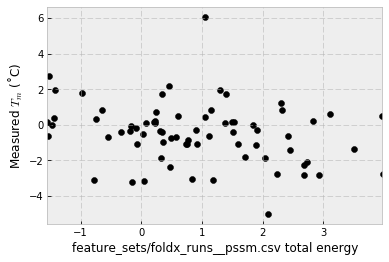


Feature set: feature_sets/rosetta_runs__benchmark.csv
hbond_sc          -0.159248
total_score       -0.000638
tot_hbond_pm       0.040308
tot_burunsat_pm    0.064251
tot_NLconts_pm     0.078305
fa_rep             0.142053
Name: target_tm, dtype: float64


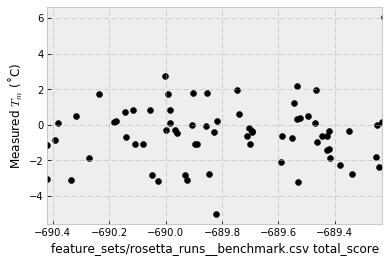

In [106]:
for i, f_set in enumerate( feature_sets ):
    X, y, J = features[ ( 'tm', f_set ) ]
    print( 'Feature set:', f_set )  
    corr = J.corr(method='pearson')['target_tm'].drop('target_tm').dropna().sort_values()
    print( corr )
    
    for feat in J.columns:
        if feat in make_plots:
            plt.scatter( J[ feat ], J[ 'target_tm' ], color='k' )
            plt.xlim( J[feat].quantile(0.05), J[feat].quantile(0.95), )
            plt.xlabel( '{} {}'.format( f_set, feat ) ) 
            plt.ylabel( 'Measured $T_m$ (˚C)' ) 
            plt.show()
    
    print()

In [107]:
feature_sets

{'feature_sets/foldx_runs__pssm.csv',
 'feature_sets/rosetta_runs__benchmark.csv',
 'feature_sets/rosetta_runs__ddg_monomer_high_res.csv'}

/Users/alex/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


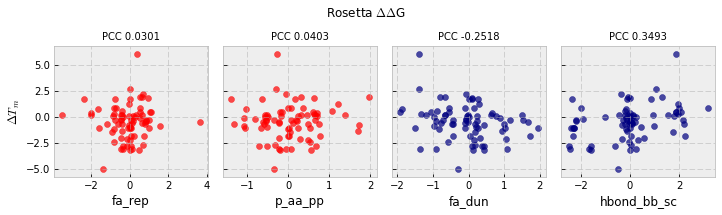

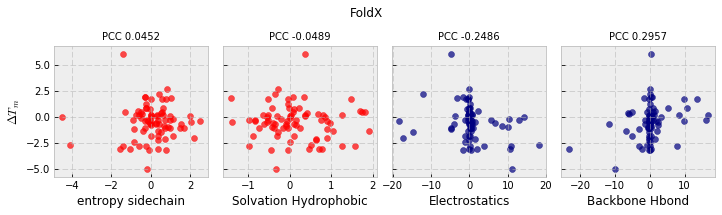

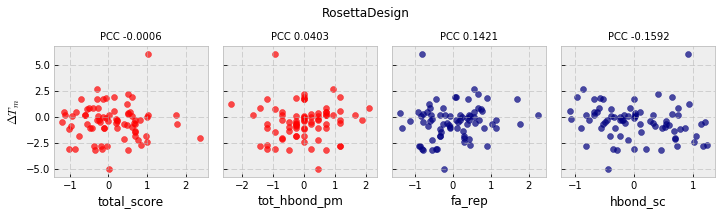

In [109]:
# plots of 5 best nd 5 worst feature for Tm paper 

feature_set_labels = {
    'feature_sets/foldx_runs__pssm.csv': 'FoldX', 
    'feature_sets/rosetta_runs__benchmark.csv': 'RosettaDesign', 
    'feature_sets/rosetta_runs__ddg_monomer_high_res.csv': 'Rosetta $\Delta \Delta$G', 
}

for i, f_set in enumerate( feature_sets ):

    # get data 
    X, y, J = features[ ( 'tm', f_set ) ] 
    X = pandas.DataFrame( X, columns=J.columns[1:] )

    # assess correlation 
    corr = J.corr()[['target_tm']].drop( 'target_tm' ).dropna()
    corr[ 'abs_corr' ] = corr.target_tm.map( abs )
    corr = corr.sort_values( 'abs_corr' ) 
    
    fig, ax = plt.subplots( nrows=1, ncols=4, sharey=True, figsize=(10,3) ) 
    fig.suptitle( feature_set_labels[f_set] )
    ax[0].set_ylabel( '$\Delta T_m$' )
    
    for i, (idx, feature) in enumerate( corr.tail(2).iterrows() ):        
        ax[ i+2 ].set_title( 'PCC {0:2.4f}'.format( feature.target_tm ), fontsize='medium' )
        ax[ i+2 ].scatter( X[idx], y, color='navy', alpha=0.7 )  
        ax[ i+2 ].set_xlabel( idx ) 

    for i, (idx, feature) in enumerate( corr.head(2).iterrows() ):
        ax[ i ].set_title( 'PCC {0:2.4f}'.format( feature.target_tm ), fontsize='medium' )
        ax[ i ].scatter( X[idx], y, color='red', alpha=0.7 )  
        ax[ i ].set_xlabel( idx ) 
        #ax[ i ].set_xlim( X[idx].min(), X[idx].max() )
        
    fig.tight_layout()
    fig.subplots_adjust( wspace=0.1, top=0.8 )
    fig.show()